In [ ]:
pip install torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 11.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.w

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchattacks

##Load the CIFAR-10 dataset

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),
                                 (0.5, 0.5, 0.5))])

batch_size=64;


train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:11<00:00, 15031342.02it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


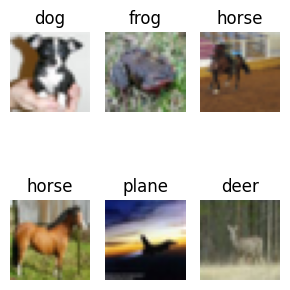

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

batch_size = 6

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Define the figure size
plt.figure(figsize=(3, 4))  # 6 columns and 4 rows

# Show images and print labels for the first 6 images
for i in range(batch_size):
    plt.subplot(2, 3, i+1)  # 2 rows, 3 columns, i+1 denotes the position of the subplot
    imshow(torchvision.utils.make_grid(images[i]))
    plt.title(f"{classes[labels[i]]}")
    plt.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()

## Define the model architecture

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))) #This line applies the first convolutional layer (conv1) to the input x, then applies the ReLU activation function (torch.relu)
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8) #This line reshapes (flattens) the output tensor x from the previous layer to prepare it for the fully connected layers.
        x = torch.relu(self.fc1(x)) #This applies the ReLU activation function to the output of the first fully connected layer (fc1).
        x = self.fc2(x) #This applies the second fully connected layer (fc2) to produce the final output tensor x
        return x

## Check if GPU is available and set the device accordingly

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = SimpleCNN().to(device)

## Define a Loss function and optimizer.
Using a Classification Cross-Entropy loss and Adam with momentum.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 5
for epoch in range(num_epochs): # loop over the dataset multiple times
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader: # get the inputs; images.to(device), labels.to(device) is a list of [images, labels]
        images, labels = images.to(device), labels.to(device)  # Move data to GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = correct_val / total_val

    # Print training and validation statistics
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch 1/5, Loss: 1.3201, Train Accuracy: 0.5281, Val Accuracy: 0.6277
Epoch 2/5, Loss: 0.9532, Train Accuracy: 0.6662, Val Accuracy: 0.6670
Epoch 3/5, Loss: 0.8015, Train Accuracy: 0.7180, Val Accuracy: 0.7065
Epoch 4/5, Loss: 0.6835, Train Accuracy: 0.7620, Val Accuracy: 0.7064
Epoch 5/5, Loss: 0.5835, Train Accuracy: 0.7970, Val Accuracy: 0.7245


##Saving our trained model

In [ ]:
torch.save(model.state_dict(), 'cifar10_model.pth')

##Test the network on the test data
We have trained the network for 5 epoch over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

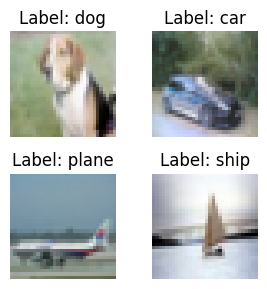

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
# Define the figure size
plt.figure(figsize=(3, 3))  # 3 columns and 4 rows

# Print images and labels for the first 4 images
for i in range(min(4, len(labels))):
    plt.subplot(2, 2, i+1)  # 2 rows, 2 columns, i+1 denotes the position of the subplot
    imshow(torchvision.utils.make_grid(images[i]))
    plt.title(f"Label: {classes[labels[i]]}")
    plt.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()


##Load the pre trained model

In [ ]:
model = SimpleCNN().to(device)
model.load_state_dict(torch.load('cifar10_model.pth'))

<All keys matched successfully>

In [ ]:
outputs = model(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  dog   car   plane ship 


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 72 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 78.7 %
Accuracy for class: car   is 81.0 %
Accuracy for class: bird  is 63.2 %
Accuracy for class: cat   is 44.9 %
Accuracy for class: deer  is 69.9 %
Accuracy for class: dog   is 59.3 %
Accuracy for class: frog  is 78.5 %
Accuracy for class: horse is 79.1 %
Accuracy for class: ship  is 85.2 %
Accuracy for class: truck is 84.7 %


##FGSM attack

Original Label: 6
The image has likely been attacked by an adversarial perturbation.


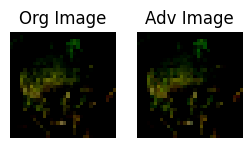

Original Prediction: frog
Adversarial Prediction: ship
Success Rate: 0.0001


In [ ]:

# Define the FGSM attack
attack_FGSM = torchattacks.FGSM(model, eps=8/255)

# Choose a random data point from the test dataset
index_FGSM = np.random.randint(0, len(test_dataset))
original_image_FGSM, original_label_FGSM = test_dataset[index_FGSM]
print("Original Label:", original_label_FGSM)

# Ensure original_label is a PyTorch tensor
original_label_tensor_FGSM = torch.tensor(original_label_FGSM)

# Apply the FGSM attack to the original image
adv_images_FGSM = attack_FGSM(original_image_FGSM.unsqueeze(0), original_label_tensor_FGSM.unsqueeze(0))

# Predictions on original and adversarial images
original_prediction_FGSM = torch.argmax(model(original_image_FGSM.unsqueeze(0)))
adversarial_prediction_FGSM = torch.argmax(model(adv_images_FGSM))

# Check if the predictions differ
if original_prediction_FGSM != adversarial_prediction_FGSM:
    print("The image has likely been attacked by an adversarial perturbation.")
else:
    print("The image has not been attacked by an adversarial perturbation.")


# Visualize the original image and adversarial image along with their predictions
fig, axs = plt.subplots(1, 2, figsize=(3, 5))

# Original image
axs[0].imshow(np.transpose(original_image_FGSM.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[0].set_title("Org Image")
axs[0].axis('off')

# Adversarial image
axs[1].imshow(np.transpose(adv_images_FGSM.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[1].set_title("Adv Image")
axs[1].axis('off')

plt.show()

# Print the original and adversarial predictions
print("Original Prediction:", classes[original_prediction_FGSM.item()])
print("Adversarial Prediction:", classes[adversarial_prediction_FGSM.item()])


# Check if the predictions differ

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = len(test_dataset)


if original_prediction_FGSM != adversarial_prediction_FGSM:
  successful_attacks += 1

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print("Success Rate:", success_rate)

# UPGD attack

Original Label: 7
The image has likely been attacked by an adversarial perturbation.
Original Prediction: horse
Adversarial Prediction: plane


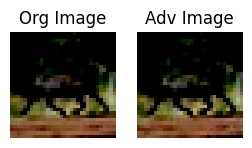

Original Prediction: horse
Adversarial Prediction: plane
Success Rate: 0.0001


In [ ]:
# Define the UPGD attack
attack_UPGD = torchattacks.UPGD(model, eps=8/255, alpha=2/255, steps=10, random_start=False)

# Choose a random data point from the test dataset
index_UPGD = np.random.randint(0, len(test_dataset))
original_image_UPGD, original_label_UPGD = test_dataset[index_UPGD]
print("Original Label:", original_label_UPGD)

# Ensure original_label is a PyTorch tensor
original_label_tensor_UPGD = torch.tensor(original_label_UPGD)

# Apply the UPGD attack to the original image
adv_images_UPGD = attack_UPGD(original_image_UPGD.unsqueeze(0), original_label_tensor_UPGD.unsqueeze(0))

# Predictions on original and adversarial images
original_prediction_UPGD = torch.argmax(model(original_image_UPGD.unsqueeze(0)))
adversarial_prediction_UPGD = torch.argmax(model(adv_images_UPGD))

# Check if the predictions differ
if original_prediction_UPGD != adversarial_prediction_UPGD:
    print("The image has likely been attacked by an adversarial perturbation.")
else:
    print("The image has not been attacked by an adversarial perturbation.")

# Print the original and adversarial predictions
print("Original Prediction:", classes[original_prediction_UPGD.item()])
print("Adversarial Prediction:", classes[adversarial_prediction_UPGD.item()])

# Visualize the original image and adversarial image along with their predictions
fig, axs = plt.subplots(1, 2, figsize=(3, 5))

# Original image
axs[0].imshow(np.transpose(original_image_UPGD.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[0].set_title("Org Image")
axs[0].axis('off')

# Adversarial image
axs[1].imshow(np.transpose(adv_images_UPGD.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[1].set_title("Adv Image")
axs[1].axis('off')

plt.show()

# Print the original and adversarial predictions
print("Original Prediction:", classes[original_prediction_UPGD.item()])
print("Adversarial Prediction:", classes[adversarial_prediction_UPGD.item()])

# Check if the predictions differ

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = len(test_dataset)

if original_prediction_UPGD != adversarial_prediction_UPGD:
  successful_attacks += 1

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print("Success Rate:", success_rate)

##APGD attack

Original Label: 2
The image has not been attacked by an adversarial perturbation.
Original Prediction: plane
Adversarial Prediction: plane


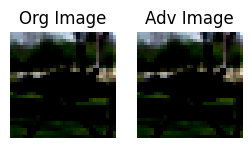

Original Prediction: plane
Adversarial Prediction: plane
Success Rate: 0.0


In [ ]:
# Define the APGD attack
attack_APGD = torchattacks.APGD(model, norm='Linf', eps=8/255, steps=10, n_restarts=1, seed=0, loss='ce', eot_iter=1, rho=.75, verbose=False)

# Choose a random data point from the test dataset
index_APGD = np.random.randint(0, len(test_dataset))
original_image_APGD, original_label_APGD = test_dataset[index_APGD]
print("Original Label:", original_label_APGD)

# Ensure original_label is a PyTorch tensor
original_label_tensor_APGD = torch.tensor(original_label_APGD)

# Apply the APGD attack to the original image
adv_images_APGD = attack_APGD(original_image_APGD.unsqueeze(0), original_label_tensor_APGD.unsqueeze(0))

# Predictions on original and adversarial images
original_prediction_APGD = torch.argmax(model(original_image_APGD.unsqueeze(0)))
adversarial_prediction_APGD = torch.argmax(model(adv_images_APGD))

# Check if the predictions differ
if original_prediction_APGD != adversarial_prediction_APGD:
    print("The image has likely been attacked by an adversarial perturbation.")
else:
    print("The image has not been attacked by an adversarial perturbation.")

# Print the original and adversarial predictions
print("Original Prediction:", classes[original_prediction_APGD.item()])
print("Adversarial Prediction:", classes[adversarial_prediction_APGD.item()])

# Visualize the original image and adversarial image along with their predictions
fig, axs = plt.subplots(1, 2, figsize=(3, 5))

# Original image
axs[0].imshow(np.transpose(original_image_APGD.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[0].set_title("Org Image")
axs[0].axis('off')

# Adversarial image
axs[1].imshow(np.transpose(adv_images_APGD.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[1].set_title("Adv Image")
axs[1].axis('off')

plt.show()

# Print the original and adversarial predictions
print("Original Prediction:", classes[original_prediction_APGD.item()])
print("Adversarial Prediction:", classes[adversarial_prediction_APGD.item()])

# Check if the predictions differ

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = len(test_dataset)

if original_prediction_APGD != adversarial_prediction_APGD:
  successful_attacks += 1

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print("Success Rate:", success_rate)

##APGDT attack

Original Label: 0
The image has likely been attacked by an adversarial perturbation.
Original Prediction: plane
Adversarial Prediction: ship


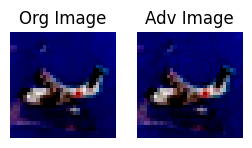

Original Prediction: plane
Adversarial Prediction: ship
Success Rate: 0.0001


In [ ]:
# Define the APGDT attack
attack_APGDT = torchattacks.APGDT(model, norm='Linf', eps=8/255, steps=10, n_restarts=1, seed=0, eot_iter=1, rho=.75, verbose=False, n_classes=10)

# Choose a random data point from the test dataset
index_APGDT = np.random.randint(0, len(test_dataset))
original_image_APGDT, original_label_APGDT = test_dataset[index_APGDT]
print("Original Label:", original_label_APGDT)

# Ensure original_label is a PyTorch tensor
original_label_tensor_APGDT = torch.tensor(original_label_APGDT)

# Apply the APGDT attack to the original image
adv_images_APGDT = attack_APGDT(original_image_APGDT.unsqueeze(0), original_label_tensor_APGDT.unsqueeze(0))

# Predictions on original and adversarial images
original_prediction_APGDT = torch.argmax(model(original_image_APGDT.unsqueeze(0)))
adversarial_prediction_APGDT = torch.argmax(model(adv_images_APGDT))

# Check if the predictions differ
if original_prediction_APGDT != adversarial_prediction_APGDT:
    print("The image has likely been attacked by an adversarial perturbation.")
else:
    print("The image has not been attacked by an adversarial perturbation.")

# Print the original and adversarial predictions
print("Original Prediction:", classes[original_prediction_APGDT.item()])
print("Adversarial Prediction:", classes[adversarial_prediction_APGDT.item()])

# Visualize the original image and adversarial image along with their predictions
fig, axs = plt.subplots(1, 2, figsize=(3, 5))

# Original image
axs[0].imshow(np.transpose(original_image_APGDT.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[0].set_title("Org Image")
axs[0].axis('off')

# Adversarial image
axs[1].imshow(np.transpose(adv_images_APGDT.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[1].set_title("Adv Image")
axs[1].axis('off')

plt.show()

# Print the original and adversarial predictions
print("Original Prediction:", classes[original_prediction_APGDT.item()])
print("Adversarial Prediction:", classes[adversarial_prediction_APGDT.item()])

# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = len(test_dataset)

if original_prediction_APGDT != adversarial_prediction_APGDT:
  successful_attacks += 1

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print("Success Rate:", success_rate)

##DIFGSM attack

Original Label: 7
The image has likely been attacked by an adversarial perturbation.
Original Prediction: horse
Adversarial Prediction: ship


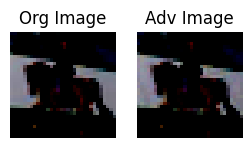

Original Prediction: horse
Adversarial Prediction: ship
Success Rate: 0.0001


In [ ]:
# Define the DIFGSM attack
attack_DIFGSM = torchattacks.DIFGSM(model, eps=8/255, alpha=2/255, steps=10, decay=0.0, resize_rate=0.9, diversity_prob=0.5, random_start=False)

# Choose a random data point from the test dataset
index_DIFGSM = np.random.randint(0, len(test_dataset))
original_image_DIFGSM, original_label_DIFGSM = test_dataset[index_DIFGSM]
print("Original Label:", original_label_DIFGSM)

# Ensure original_label is a PyTorch tensor
original_label_tensor_DIFGSM = torch.tensor(original_label_DIFGSM)

# Apply the DIFGSM attack to the original image
adv_images_DIFGSM = attack_DIFGSM(original_image_DIFGSM.unsqueeze(0), original_label_tensor_DIFGSM.unsqueeze(0))

# Predictions on original and adversarial images
original_prediction_DIFGSM = torch.argmax(model(original_image_DIFGSM.unsqueeze(0)))
adversarial_prediction_DIFGSM = torch.argmax(model(adv_images_DIFGSM))

# Check if the predictions differ
if original_prediction_DIFGSM != adversarial_prediction_DIFGSM:
    print("The image has likely been attacked by an adversarial perturbation.")
else:
    print("The image has not been attacked by an adversarial perturbation.")

# Print the original and adversarial predictions
print("Original Prediction:", classes[original_prediction_DIFGSM.item()])
print("Adversarial Prediction:", classes[adversarial_prediction_DIFGSM.item()])

# Visualize the original image and adversarial image along with their predictions
fig, axs = plt.subplots(1, 2, figsize=(3, 5))

# Original image
axs[0].imshow(np.transpose(original_image_DIFGSM.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[0].set_title("Org Image")
axs[0].axis('off')

# Adversarial image
axs[1].imshow(np.transpose(adv_images_DIFGSM.squeeze().detach().cpu().numpy(), (1, 2, 0)))
axs[1].set_title("Adv Image")
axs[1].axis('off')

plt.show()

# Print the original and adversarial predictions
print("Original Prediction:", classes[original_prediction_DIFGSM.item()])
print("Adversarial Prediction:", classes[adversarial_prediction_DIFGSM.item()])


# Initialize variables to count successful attacks
successful_attacks = 0
total_samples = len(test_dataset)

if original_prediction_DIFGSM != adversarial_prediction_DIFGSM:
  successful_attacks += 1

# Calculate the success rate
success_rate = successful_attacks / total_samples

# Print the success rate
print("Success Rate:", success_rate)

##Comparing all attacks

In [108]:
# Define the FGSM attack
attack_FGSM = torchattacks.FGSM(model, eps=8/255)

# Define the UPGD attack
attack_UPGD = torchattacks.UPGD(model, eps=8/255, alpha=2/255, steps=10, random_start=False)

# Define the APGD attack
attack_APGD = torchattacks.APGD(model, norm='Linf', eps=8/255, steps=10, n_restarts=1, seed=0, loss='ce', eot_iter=1, rho=.75, verbose=False)

# Define the APGDT attack
attack_APGDT = torchattacks.APGDT(model, norm='Linf', eps=8/255, steps=10, n_restarts=1, seed=0, eot_iter=1, rho=.75, verbose=False, n_classes=10)

# Define the DIFGSM attack
attack_DIFGSM = torchattacks.DIFGSM(model, eps=8/255, alpha=2/255, steps=10, decay=0.0, resize_rate=0.9, diversity_prob=0.5, random_start=False)



# Initialize variables to count successful attacks
successful_attacks_FGSM = 0
successful_attacks_UPGD = 0
successful_attacks_APGD = 0
successful_attacks_APGDT = 0
successful_attacks_DIFGSM = 0

total_samples = len(test_dataset)

# Iterate over the test dataset
for original_image, original_label in test_dataset:
    # Ensure original_label is a PyTorch tensor
    original_label_tensor = torch.tensor(original_label)

    # Apply the FGSM attack to the original image
    adv_images_FGSM = attack_FGSM(original_image.unsqueeze(0), original_label_tensor.unsqueeze(0))
    # Apply the UPGD attack to the original image
    adv_images_UPGD = attack_UPGD(original_image.unsqueeze(0), original_label_tensor.unsqueeze(0))
    # Apply the APGD attack to the original image
    adv_images_APGD = attack_APGD(original_image.unsqueeze(0), original_label_tensor.unsqueeze(0))
    # Apply the APGDT attack to the original image
    adv_images_APGDT = attack_APGDT(original_image.unsqueeze(0), original_label_tensor.unsqueeze(0))
    # Apply the DIFGSM attack to the original image
    adv_images_DIFGSM = attack_DIFGSM(original_image.unsqueeze(0), original_label_tensor.unsqueeze(0))


    # Predictions on original and adversarial images
    original_prediction = torch.argmax(model(original_image.unsqueeze(0)))
    adversarial_prediction_FGSM = torch.argmax(model(adv_images_FGSM))
    adversarial_prediction_UPGD = torch.argmax(model(adv_images_UPGD))
    adversarial_prediction_APGD = torch.argmax(model(adv_images_APGD))
    adversarial_prediction_APGDT = torch.argmax(model(adv_images_APGDT))
    adversarial_prediction_DIFGSM = torch.argmax(model(adv_images_DIFGSM))


    # Check if the predictions differ for FGSM attack
    if original_prediction != adversarial_prediction_FGSM:
        successful_attacks_FGSM += 1

    # Check if the predictions differ for UPGD attack
    if original_prediction != adversarial_prediction_UPGD:
        successful_attacks_UPGD += 1

    # Check if the predictions differ for APGD attack
    if original_prediction != adversarial_prediction_APGD:
        successful_attacks_APGD += 1

    # Check if the predictions differ for APGDT attack
    if original_prediction != adversarial_prediction_APGDT:
        successful_attacks_APGDT += 1

    # Check if the predictions differ for DIFGSM attack
    if original_prediction != adversarial_prediction_DIFGSM:
        successful_attacks_DIFGSM += 1



# Calculate the success rate for each attack
success_rate_FGSM = successful_attacks_FGSM / total_samples
success_rate_UPGD = successful_attacks_UPGD / total_samples
success_rate_APGD = successful_attacks_APGD / total_samples
success_rate_APGDT = successful_attacks_APGDT / total_samples
success_rate_DIFGSM = successful_attacks_DIFGSM / total_samples


# Print the success rates for each attack
print("FGSM Success Rate:", success_rate_FGSM)
print("UPGD Success Rate:", success_rate_UPGD)
print("APGD Success Rate:", success_rate_APGD)
print("APGDT Success Rate:", success_rate_APGDT)
print("DIFGSM Success Rate:", success_rate_DIFGSM)


# Compare which attack has the highest success rate
highest_success_rate = max(success_rate_FGSM, success_rate_UPGD, success_rate_APGD, success_rate_APGDT, success_rate_DIFGSM)
if highest_success_rate == success_rate_FGSM:
    print("FGSM has the highest success rate.")
elif highest_success_rate == success_rate_UPGD:
    print("UPGD has the highest success rate.")
elif highest_success_rate == success_rate_APGD:
    print("APGD has the highest success rate.")
elif highest_success_rate == success_rate_APGDT:
    print("APGDT has the highest success rate.")
else:
    print("DIFGSM has the highest success rate.")

FGSM Success Rate: 0.7469
UPGD Success Rate: 0.8651
APGD Success Rate: 0.6852
APGDT Success Rate: 0.6893
DIFGSM Success Rate: 0.8637
UPGD has the highest success rate.
